---
# Install the required packages

If needed install the following packages:

In [3]:
!pip install datasets transformers imbalanced-learn evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


---
# Imports

In [37]:
from datasets import load_dataset
from transformers import AutoTokenizer,DataCollatorWithPadding,DistilBertForSequenceClassification,TrainingArguments, Trainer
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

---
# Laboratory Exercise - Run Mode (8 points)

## Introduction

This laboratory assignment's primary objective is to fine-tune a pre-trained language model for detection of toxic sentences (binary classification).

The dataset contains two attributes:
- `text`: The sentence which needs to be classified in to toxic/non-toxic
- `label`: 0/1 indicator if the given sentence is toxic

**Note: You are required to perform this laboratory assignment on your local machine.**

# Read the data

The dataset reading is given. Just run the following 2 cells.

**DO NOT MODIFY IT! Just analyse how the data reading was performed, as in the future this part won't be given.**

In [7]:
dataset = load_dataset(
    'csv',
    data_files={'train': 'train.tsv', 'val': 'val.tsv','test': 'test.tsv'},
    delimiter='\t'
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

**The prediction target column MUST be named 'label' in the dataset !**

See the dataset structure:

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 3130
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3132
    })
})

---
# Natural Language Processing

## Generate the Tokenizer and Data Collator

For the purposes of this lab you will be using `DistilBertTokenizer` and `DataCollatorWithPadding`.

In [9]:
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Tokenize the dataset

For the purposes of lowering the amount of computing set the `max_length` parameter to 15.

In [11]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [12]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3130 [00:00<?, ? examples/s]

Map:   0%|          | 0/3132 [00:00<?, ? examples/s]

## Define the model

The required model for this lab is the `DistilBertForSequenceClassification`.

In [13]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define the training arguments

For lowering the compute time I recommend using the following parameters:
- per_device_train_batch_size=128
- per_device_eval_batch_size=128
- **num_train_epochs=1**

In [25]:
training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    metric_for_best_model="f1",
    report_to="none"
    )

## Load the metrics

Load the best metric for the this specific problem.

In [26]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

### Define the function to compute the metrics

In [27]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

## Generate the Trainer object

In [28]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

## Train the model

Use the trainer to train the model.

In [29]:
trainer.train()


Epoch,Training Loss,Validation Loss,F1
1,No log,0.256868,0.924694
2,No log,0.152675,0.952089
3,No log,0.136279,0.954652


TrainOutput(global_step=24, training_loss=0.2428240180015564, metrics={'train_runtime': 17.6663, 'train_samples_per_second': 169.814, 'train_steps_per_second': 1.359, 'total_flos': 19876319207712.0, 'train_loss': 0.2428240180015564, 'epoch': 3.0})

---
# Evaluate the model

In [30]:
trainer.evaluate()


{'eval_loss': 0.13627907633781433,
 'eval_f1': 0.9546517760021404,
 'eval_runtime': 2.4902,
 'eval_samples_per_second': 1257.729,
 'eval_steps_per_second': 10.039,
 'epoch': 3.0}

## Generate predictions for the test set

In [31]:
predictions = trainer.predict(tokenized_dataset["test"])


## Extract the predictions (class 0 or 1) from the logits

In [32]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

## Analyze the performance of the model

In [34]:
print(classification_report(labels, preds))


              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1566
           1       0.97      0.94      0.95      1566

    accuracy                           0.95      3132
   macro avg       0.96      0.95      0.95      3132
weighted avg       0.96      0.95      0.95      3132



Text(0.5, 1.0, 'Confusion Matrix')

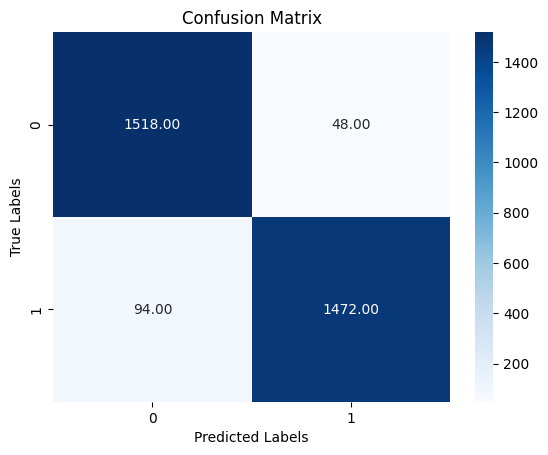

In [35]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify if a given text is **toxic** or not. Use TF-IDF vectorization to convert text into numerical features and train a `MultinomialNB` model. If needed use `RandomUnderSampler()`. Compare the results with the transformer model.

In [38]:
pipeline = make_pipeline(
    TfidfVectorizer(),
    RandomUnderSampler(),
    MultinomialNB()
)

In [39]:
pipeline.fit(dataset['train']['text'], dataset['train']['label'])

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomundersampler', RandomUnderSampler()),
                ('multinomialnb', MultinomialNB())])

In [40]:
preds_nb = pipeline.predict(dataset['test']['text'])


In [41]:
print(classification_report(dataset['test']['label'], preds_nb))


              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1566
           1       0.75      0.87      0.81      1566

    accuracy                           0.79      3132
   macro avg       0.80      0.79      0.79      3132
weighted avg       0.80      0.79      0.79      3132



---